# House prices prediction

Link on competition dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques



# Imports

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Commonly used constants and paths
SEED = 42
DATA_PATH = #SET PATH
TRAIN_PATH = f'{DATA_PATH}/train.csv'
TEST_PATH = f'{DATA_PATH}/test.csv'
DESCRIPTION = f'{DATA_PATH}/data_description.txt'
TARGET = 'SalePrice'
NAN_CATEGORY = '<NAN>'

# Functions

In [ ]:
def univariate_regplot(x, y, data):
    ax = sns.regplot(x=x, y=y, data=data)
    ax.set_title(f'{y} and {x} relationship')
    return ax

# Contents:  
1. **gradient descend**  
Basic step of every machine learning training pipeline.  
Literally it is a *learning* step  
2. **train/test split + cross validation** (kfold, timeseries split)  
train - to fit model,   
validation - to tune hyperparameters,  
test - to get final score, assess generalization power of model, find under/over- fitting  
3. **regression problem / model trainig pipeline in sklearn** 
sklearn model interface  
prepare data -> get model instance -> choose metric and loss function -> fit on train -> predict on test -> get final score -> repeat if nessesary  
4. **metrics**   
5. **regularization** 
6. **grid search** 

# Gradient descend

In [ ]:
# m denotes the number of examples here, not the number of features
def gradientDescent(x, y, theta, alpha, m, num_iterations):
    """
    run gradient descent cycle 

    x - train data
    y - target
    theta - initial parameter estimations
    alpha - learning rate
    m - number of examples in x
    """
    xTrans = x.transpose()
    history = []
    for i in range(0, num_iterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        # avg cost per example (the 2 in 2*m doesn't really matter here.
        # But to be consistent with the gradient, I include it)
        cost = np.sum(loss ** 2) / (2 * m)
        if i%1000 == 0:
            print(f"Iteration {i} | Cost: {cost} | Theta: {theta}")
        if i==num_iterations-1:
            print(f"Loss on final step: {cost} | Theta: {theta}")
        # avg gradient per example

        gradient = np.dot(xTrans, loss) / m
        # update
        theta = theta - alpha * gradient
        #log history
        history.append({'cost':cost,'theta':theta})
    return theta, history


def genData(numPoints, intercept, slope, variance):
    """
    generate syntetic dataset
    
    numPoints - number of observations in generated dataset
    intercept, slope - ground truth parameters of equation
    variance - synthetic noize value
    """
    x = np.zeros(shape=(numPoints, 2))
    y = np.zeros(shape=numPoints)
    # basically a straight line
    for i in range(0, numPoints):
        # bias feature
        x[i][0] = 1
        x[i][1] = i
        # our target variable
        y[i] = (slope * i + intercept) + random.uniform(-1, 1) * variance
    return x, y

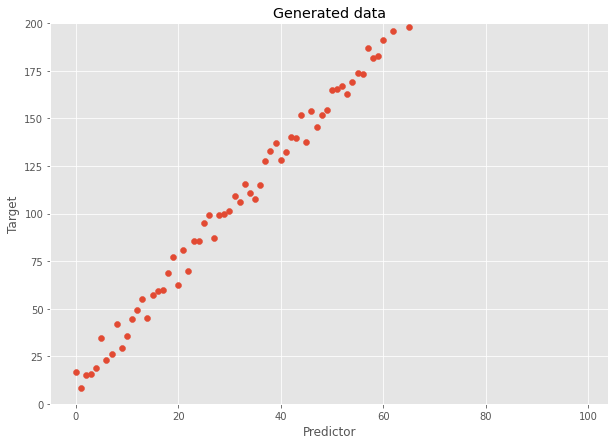

In [ ]:
x, y = genData(100, 12, 3, 10)
plt.scatter(x[:,1],y);
plt.ylim([0,200]);
plt.title('Generated data');
plt.ylabel('Target');
plt.xlabel('Predictor');

In [ ]:
m, n = np.shape(x)
numIterations = 50000
alpha = 0.0005
theta_initial = np.ones(n)
theta, history = gradientDescent(x, y, theta_initial, alpha, m, numIterations)
print(theta)

Iteration 0 | Cost: 7784.303482717294 | Theta: [1. 1.]
Iteration 1000 | Cost: 24.06745701793842 | Theta: [2.1503122  3.15642905]
Iteration 2000 | Cost: 22.12647245960792 | Theta: [3.13470743 3.14158777]
Iteration 3000 | Cost: 20.620455974896895 | Theta: [4.00181569 3.12851478]
Iteration 4000 | Cost: 19.451932689903742 | Theta: [4.76561128 3.11699938]
Iteration 5000 | Cost: 18.545271520233214 | Theta: [5.43840351 3.106856  ]
Iteration 6000 | Cost: 17.841790051660556 | Theta: [6.03103508 3.09792117]
Iteration 7000 | Cost: 17.295956400479753 | Theta: [6.55305685 3.09005088]
Iteration 8000 | Cost: 16.872442224099377 | Theta: [7.0128817  3.08311832]
Iteration 9000 | Cost: 16.543836141995243 | Theta: [7.41792015 3.07701174]
Iteration 10000 | Cost: 16.28886957129217 | Theta: [7.77469981 3.07163273]
Iteration 11000 | Cost: 16.09104014659066 | Theta: [8.08897052 3.06689462]
Iteration 12000 | Cost: 15.937543626753495 | Theta: [8.36579706 3.06272103]
Iteration 13000 | Cost: 15.818445157768583 | T

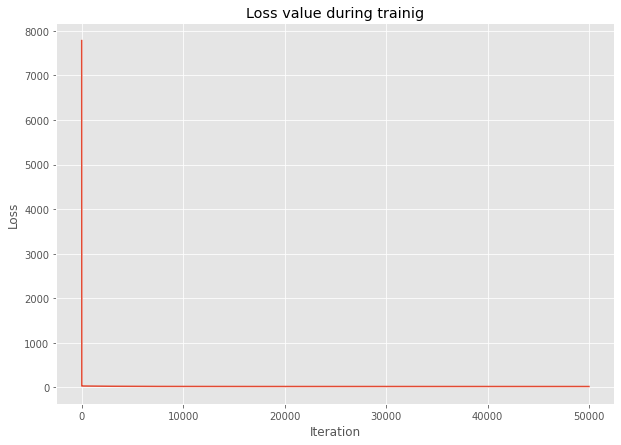

In [ ]:
plt.plot(list(map(lambda x: x['cost'], history)));
plt.ylabel('Loss');
plt.xlabel('Iteration');
plt.title('Loss value during trainig');

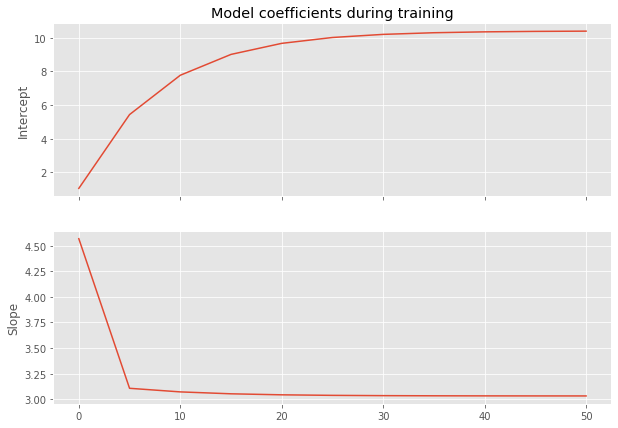

In [ ]:
intercepts = list(map(lambda x: x['theta'][0], history))
slopes = list(map(lambda x: x['theta'][1], history))

intercepts = [intercepts[i] for i in range(len(intercepts)) if i%5000==0 or i==0 or i==len(intercepts)-1]
slopes = [slopes[i] for i in range(len(slopes)) if i%5000==0 or i==0 or i==len(slopes)-1]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True);
ax1.set_title('Model coefficients during training');
ax1.plot(intercepts);
ax1.set_ylabel('Intercept');

ax2.plot(slopes);
ax2.set_ylabel('Slope');
ax2.set_xticklabels(['0','0','10','20','30','40','50']);

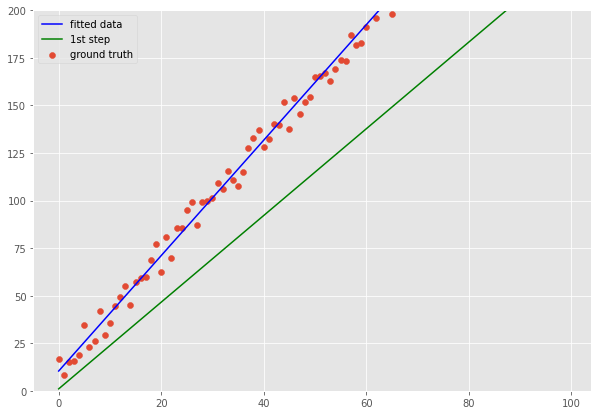

In [ ]:
plt.scatter(list(map(lambda x: x[1], x)), y);
plt.plot(np.dot(x, theta), 'blue');

plt.plot(np.dot(x, history[1]['theta']),'green');

plt.legend(['fitted data', '1st step', 'ground truth']);
plt.ylim([0,200]);

## Loss function vs Quality metric

**Loss function** - always differentiable. Used by model to tune parameters.   Doesn't have meaningful interpretation. Varies from 0 to Inf.  
**Quality metric** - not always differentiable. Used by scientist. Has interpetation (fraction of right answers, mean difference between GT and predicted values)

In [ ]:
ev_1 = metrics.r2_score(y, np.dot(x, history[0]['theta']))
ev_final = metrics.r2_score(y, np.dot(x, theta))

pd.DataFrame.from_dict({'first iteration':ev_1, 'last iteration':ev_final}, 
                          orient='index',
                          columns=['R squared'])

,R squared
first iteration,0.161207
last iteration,0.995993


# How everything works in sklearn

## EDA

### Download&overview

In [ ]:
train = pd.read_csv(TRAIN_PATH, index_col=0)
test = pd.read_csv(TEST_PATH, index_col=0)
full_house = pd.concat([train, test], sort=False)
full_house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [ ]:
full_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [ ]:
with open(DESCRIPTION, 'r') as f:
   info = f.read()
print(info)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [ ]:
# categories described as numbers
mssubclass_mapping = {
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45: '1-1/2 STORY - UNFINISHED ALL AGES',
    50: '1-1/2 STORY FINISHED ALL AGES',
    60: '2-STORY 1946 & NEWER',
    70: '2-STORY 1945 & OLDER',
    75: '2-1/2 STORY ALL AGES',
    80: 'SPLIT OR MULTI-LEVEL',
    85: 'SPLIT FOYER',
    90: 'DUPLEX - ALL STYLES AND AGES',
   120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
   150: '1-1/2 STORY PUD - ALL AGES',
   160: '2-STORY PUD - 1946 & NEWER',
   180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
   190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}
mosold_mapping = dict(zip(range(1, 13), ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 
                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

full_house.loc[:, 'MSSubClass'] = full_house.MSSubClass.map(mssubclass_mapping)
full_house.loc[:, 'MoSold'] = full_house.MoSold.map(mosold_mapping)

full_house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,Feb,2008,WD,Normal,208500.0
2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,May,2007,WD,Normal,181500.0
3,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,Sep,2008,WD,Normal,223500.0
4,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,Feb,2006,WD,Abnorml,140000.0
5,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,Dec,2008,WD,Normal,250000.0


In [ ]:
# Categories with implied ordering
full_house.loc[:, 'KitchenQual'] = pd.Categorical(full_house.KitchenQual, ordered=True, categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'])
full_house.loc[:, 'OverallQual'] = pd.Categorical(full_house.OverallQual, ordered=True)
full_house.loc[:, 'OverallCond'] = pd.Categorical(full_house.OverallQual, ordered=True)
full_house.loc[:, 'YearBuilt'] = pd.Categorical(full_house.YearBuilt, ordered=True)
full_house.loc[:, 'YearRemodAdd'] = pd.Categorical(full_house.YearRemodAdd, ordered=True)
full_house.loc[:, 'MoSold'] = pd.Categorical(full_house.MoSold, ordered=True)
full_house.loc[:, 'YrSold'] = pd.Categorical(full_house.YrSold, ordered=True)
full_house.loc[:, 'GarageYrBlt'] = pd.Categorical(full_house.GarageYrBlt, ordered=True)

In [ ]:
full_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2919 non-null   object  
 1   MSZoning       2915 non-null   object  
 2   LotFrontage    2433 non-null   float64 
 3   LotArea        2919 non-null   int64   
 4   Street         2919 non-null   object  
 5   Alley          198 non-null    object  
 6   LotShape       2919 non-null   object  
 7   LandContour    2919 non-null   object  
 8   Utilities      2917 non-null   object  
 9   LotConfig      2919 non-null   object  
 10  LandSlope      2919 non-null   object  
 11  Neighborhood   2919 non-null   object  
 12  Condition1     2919 non-null   object  
 13  Condition2     2919 non-null   object  
 14  BldgType       2919 non-null   object  
 15  HouseStyle     2919 non-null   object  
 16  OverallQual    2919 non-null   category
 17  OverallCond    2919 non-null   ca

### Target variable analysis

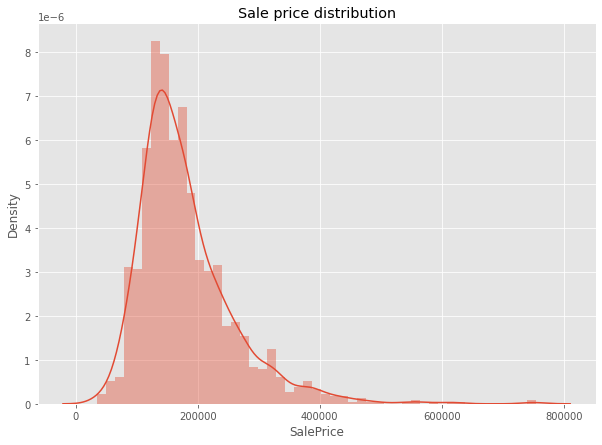

In [ ]:
ax = sns.distplot(train.SalePrice, norm_hist=True)
ax.set_title('Sale price distribution');

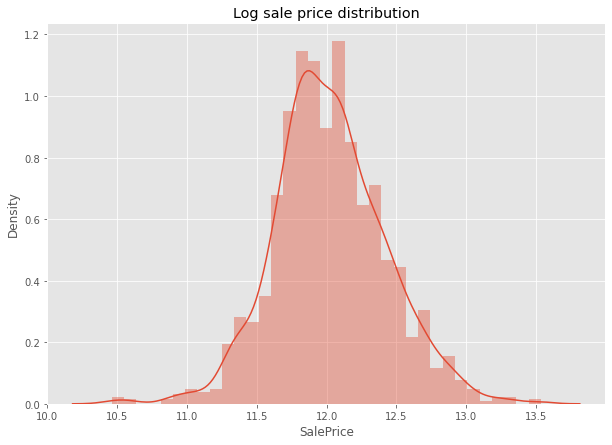

In [ ]:
ax = sns.distplot(np.log(train.SalePrice), norm_hist=True)
ax.set_title('Log sale price distribution');

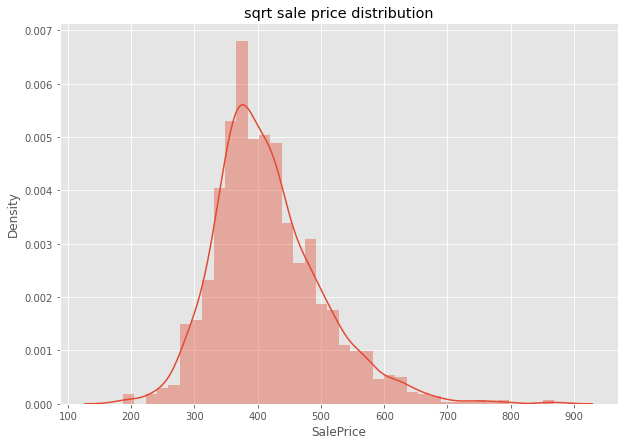

In [ ]:
ax = sns.distplot(np.sqrt(train.SalePrice), norm_hist=True)
ax.set_title('sqrt sale price distribution');

### Top correlated features

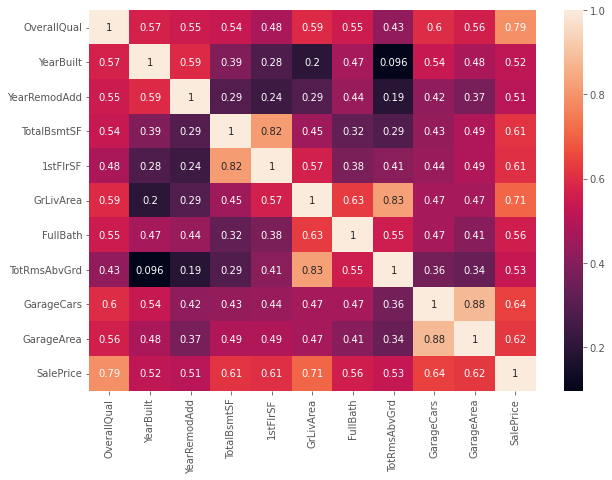

In [ ]:
corr = train.corr()
condition = np.abs(corr.SalePrice) > 0.5
top_corr = corr.loc[condition, condition]
sns.heatmap(top_corr, annot=True);

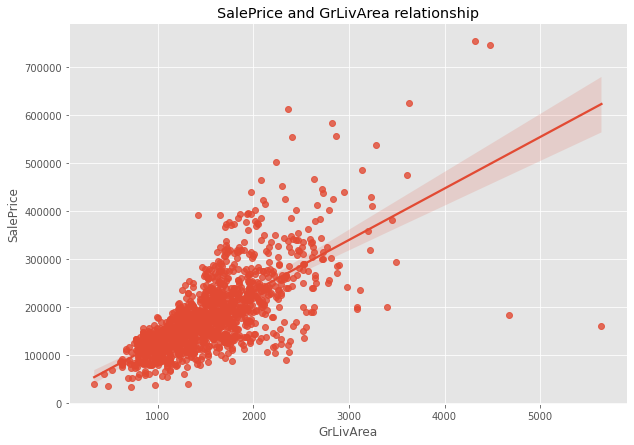

In [ ]:
univariate_regplot('GrLivArea', 'SalePrice', train);

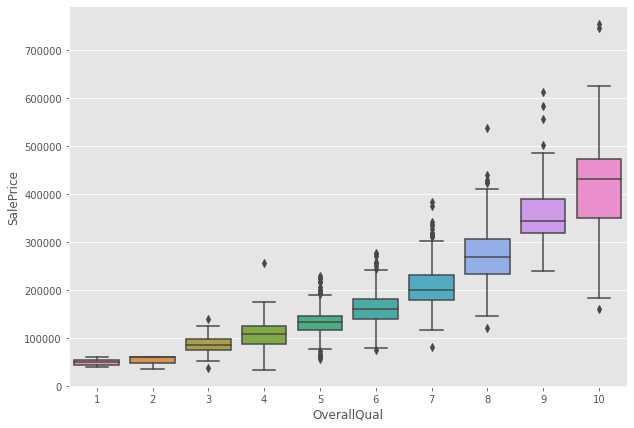

In [ ]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train)

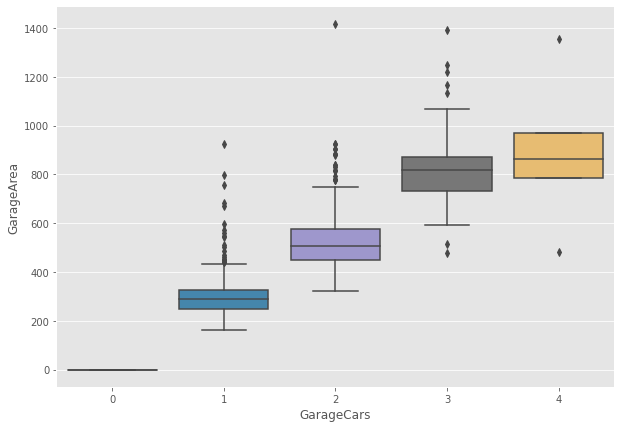

In [ ]:
sns.boxplot(y='GarageArea', x='GarageCars', data=train);

# Pipeline

## Preprocessing

### Features categorization

In [ ]:
CATEGORICAL = full_house.select_dtypes(include=['object']).columns.tolist()
ORDINAL = full_house.select_dtypes(include=['category']).columns.tolist()
NUMERICAL = full_house.select_dtypes(exclude=['category', 'object']).columns.tolist()
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [ ]:
# Apply encoding to ordinal values, .cat.categories - decoding
full_house[ORDINAL] = full_house[ORDINAL].apply(lambda x: x.cat.codes)

In [ ]:
train = full_house.loc[full_house.SalePrice.notnull()]
test = full_house.loc[full_house.SalePrice.isnull()]

### Remove obvious outliers

In [ ]:
# outliers_ind = ((train.SalePrice < 200000) & (train.GrLivArea > 4000))
# train = train.loc[~outliers_ind]
# print(train.shape)

## Split

![](https://www.brainstobytes.com/content/images/2020/01/Sets.png)

Every time we are fitting machine learning model we need to know if it works well on new data it haven't seen before.
That's why we use **TRAIN** dataset (X and y) for tuning model parameters and **TEST** dataset to calculate model performance metrics

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Important parameters:  
*train size/test size* - float from 0 to 1 as proportion of data going to either dataset. 
train size + test size = 1 (!)  
*stratify* - boolean. Valid for classification tasks. If **True** - proportions of target classes in train and test dataset

basic interface:  
train_test_split(X, y)

In [ ]:
target = train[TARGET].values
train_X, test_X, train_y, test_y = train_test_split(train.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=True, test_size = 0.2)

## Transformation

In [ ]:
# Imputing missing values

# Numerical
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': StandardScaler}
    ]
)

# Ordinal
ordinal_def = gen_features(
    columns=[[c] for c in ORDINAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'}
    ]
)

# Categorical
categorical_def = gen_features(
    columns=[[c] for c in CATEGORICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'constant', 'fill_value': 'Unknown'},
        {'class': OneHotEncoder, 'class': OneHotEncoder, 'handle_unknown': 'ignore'}
    ]    
)

In [ ]:
# 
features = numerical_def + categorical_def + ordinal_def
mapper = DataFrameMapper(features)
len(features)

79

In [ ]:
train.shape, train_X.shape, test_X.shape

((1460, 80), (1168, 79), (292, 79))

## Linear regression

### LR baseline

**Model interface in sklearn**

All model instances have more or less the same interface:  


```
model.fit(X_train, y_train)  
model.predict(X_test)  
model.score(X_test, y_test)
```


In [ ]:
# One way
train_X_tr = pd.DataFrame(mapper.fit_transform(train_X))
test_X_tr = pd.DataFrame(mapper.transform(test_X))

train_y_tr = pd.Series(np.log(train_y))
test_y_tr = pd.Series(np.log(test_y))

In [ ]:
train_X_tr.shape

(1168, 313)

In [ ]:
linreg = LinearRegression()
linreg.fit(train_X_tr, train_y_tr)
print(f'\nR2 Test Score: {linreg.score(test_X_tr, test_y_tr)}')

LinearRegression()


R2 Test Score: -623732615910.6853


In [ ]:
print(f'\nR2 Train Score: {linreg.score(train_X_tr, train_y_tr)}')


R2 Train Score: 0.9433172353421442


##### Score is VERY bad. Let's find examples where model is ridiculously wrong:

In [ ]:
preds = linreg.predict(test_X_tr)
odd_idx = np.where( np.abs(preds)>20 )[0]

In [ ]:
preds[odd_idx]

array([-3351480.50808181,   311877.70540961, -3351480.47993765,
       -3351480.15952371,   104884.68829682,  -213199.15941438,
        -369689.37646043])

In [ ]:
#remove those points from dataset

valid_examples = [index for index in test_X_tr.index if index not in odd_idx]
print(test_X_tr.shape)
test_X_tr = test_X_tr.loc[valid_examples]
print(test_X_tr.shape)
test_y_tr = test_y_tr.loc[valid_examples]

(292, 313)
(285, 313)


In [ ]:
#DO THE SAME WITH INITIAL DATA
test_X = test_X.iloc[valid_examples]
test_y = pd.Series(test_y).iloc[valid_examples]

In [ ]:
print(f'\nR2 Test Score: {linreg.score(test_X_tr, test_y_tr)}')


R2 Test Score: 0.8663122367241571


In [ ]:
#cross validation
def rmse(y_gt, Y_pr):
    return np.sqrt(mean_squared_error(y_gt, Y_pr))

print('RMSE Test: ')
print(rmse(test_y_tr, linreg.predict(test_X_tr)))
print('-'*30)

rmse_scorer = metrics.make_scorer(rmse)
print('RMSE cross-validation scores:')
CV_score = cross_val_score(linreg, train_X_tr, train_y_tr, cv=5, scoring=rmse_scorer, )
print(CV_score)
print('-'*30)

print('RMSE average cross-validation scores:')
print(np.sum(CV_score)/5)
print('-'*30)

RMSE Test: 
0.15752369084283732
------------------------------
RMSE cross-validation scores:
[2.44818544e+05 1.47300327e+07 1.43836710e-01 2.48786376e+07
 1.48399708e+07]
------------------------------
RMSE average cross-validation scores:
10938691.966193208
------------------------------


##### Self-Exercise:
figure out which of points in training data make scores THAT big

In [ ]:
#metrics
predictions = linreg.predict(test_X_tr)

mae = metrics.mean_absolute_error(test_y_tr, predictions)
mse = metrics.mean_squared_error(test_y_tr, predictions)
r2 = metrics.r2_score(test_y_tr, predictions)
rmse = np.sqrt(metrics.mean_squared_error(test_y_tr, predictions))

pd.DataFrame.from_dict({'MAE':mae, 'MSE':mse, 'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

,Score
MAE,0.097601
MSE,0.024814
R2,0.866312
RMSE,0.157524


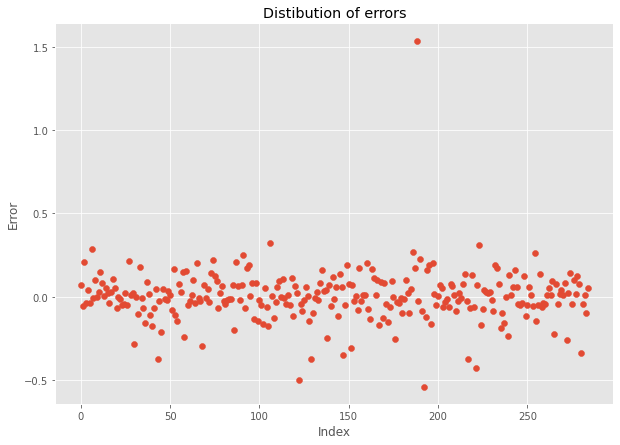

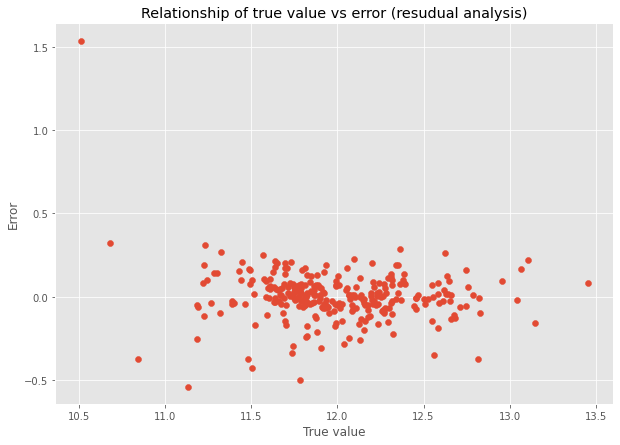

In [ ]:
#errors visualization
#can be helpful to better understand behavior of model

pred = linreg.predict(test_X_tr)
errors = test_y_tr - pred

plt.scatter(list(range(len(errors))),errors);
plt.title("Distibution of errors")
plt.ylabel('Error');
plt.xlabel('Index');
plt.show();

plt.scatter(pred,errors);
plt.title('Relationship of true value vs error (resudual analysis)')
plt.ylabel('Error');
plt.xlabel('True value');
plt.show();

### Pipeline

In [ ]:
# Evaluation

def evaluate_model(train, test, tr_y, tst_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_test = pipeline.predict(test)
    pred_train = pipeline.predict(train)
    mapper = pipeline.named_steps['mapper']

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'test_RMSE': [np.sqrt(mean_squared_error(tst_y, pred_test))],
        'test_R2': [r2_score(tst_y, pred_test)]
    }), mapper.transformed_names_

In [ ]:
# Cool way
pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', LinearRegression())
])

In [ ]:
# Evaluate the same model using $\log(y)$ instead of $y$
scores, _ = evaluate_model(train_X, test_X, train_y_tr, test_y_tr, pipeline)
scores

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.092957,0.943317,0.157524,0.866312


### Drop some features

Select only features that have a correlation coefficient with `SalePrice` more than 0.5. 

Remove from the list `GarageArea` feature as it is highly correlated with `GarageCars`

Filter currect feature_definition pipeline and fit the linear regression model only on top correlated features

In [ ]:
ind = np.abs(corr[TARGET]) > 0.5
top_corr = corr[TARGET][ind].index.tolist()
top_corr.remove(TARGET)
# top_corr.remove('GarageCars')
top_corr.remove('GarageArea')

In [ ]:
top_corr

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars']

In [ ]:
top_corr_features = [f for f in features if f[0][0] in top_corr]
pipeline = Pipeline([
    ('mapper', DataFrameMapper(top_corr_features)),
    ('estimator', LinearRegression())
])

In [ ]:
scores, colnames = evaluate_model(train_X, test_X, train_y_tr, test_y_tr, pipeline)
scores

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.169546,0.811433,0.169801,0.844662


In [ ]:
print('RMSE cross-validation scores:')

CV_score = cross_val_score(pipeline, train_X, train_y_tr, cv=5, scoring=rmse_scorer, )
print(CV_score)
print('-'*30)

print('RMSE average cross-validation scores:')
print(np.sum(CV_score)/5)
print('-'*30)

RMSE cross-validation scores:
[0.14878869 0.19077488 0.23149415 0.15914073 0.13742616]
------------------------------
RMSE average cross-validation scores:
0.1735249221493214
------------------------------


## Regularization

In [ ]:
def plot_importance(est, colnames, top_n=20):
    importance = pd.DataFrame({
        'abs_weight': np.abs(est.coef_),
        'feature': colnames
    })
    imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
    sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');

,train_RMSE,train_R2,test_RMSE,test_R2
0,19801.27124,0.934263,30709.758685,0.877968


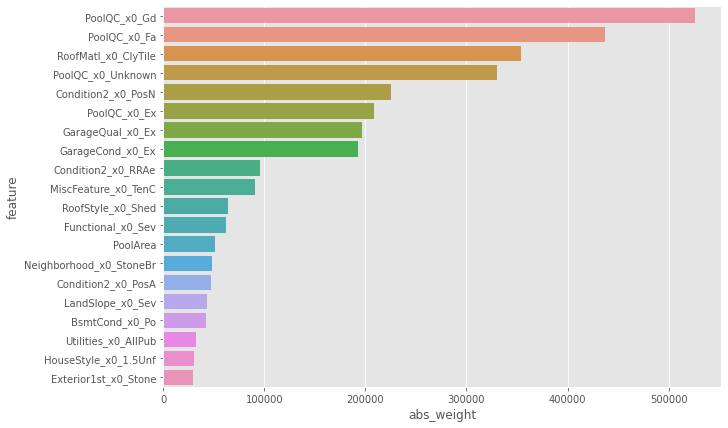

In [ ]:
lasso = Lasso() 
pipeline = Pipeline([('mapper', DataFrameMapper(features)), 
                     ('estimator', lasso)])

scores, colnames = evaluate_model(train_X, test_X, train_y, test_y, pipeline)
scores

plot_importance(pipeline.named_steps['estimator'], colnames)

,train_RMSE,train_R2,test_RMSE,test_R2
0,25358.652628,0.892186,30453.613681,0.879996


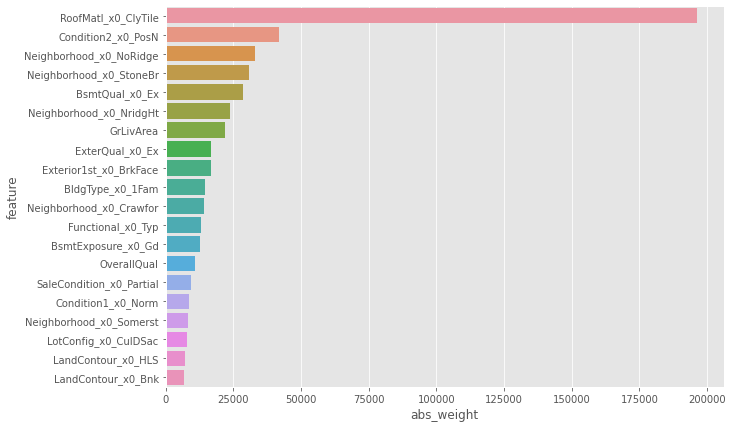

In [ ]:
# the same but with stronger regularization
# (pay attention to absolute values of coefficients)

lasso = Lasso(alpha=200)
pipeline = Pipeline([('mapper', DataFrameMapper(features)), 
                     ('estimator', lasso)])

scores, colnames = evaluate_model(train_X, test_X, train_y, test_y, pipeline)
scores

plot_importance(pipeline.named_steps['estimator'], colnames)

##### Self-Exercise:
Show dependency between top 2 features (not encoded) and target variable.

In [ ]:
#YOUR CODE

##  Hyperparameters tuning

Cross validation

![alt text](https://alexforrest.github.io/images/cv.png)

Cross-validation is train/test split and metric computation done several times (usually 3-10 depending on data)

Time series split

![alt text](https://i.stack.imgur.com/fXZ6k.png)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('estimator', ElasticNet(random_state=SEED))
])
grid = {
    'estimator__alpha': np.linspace(0, 300, 10),
    'estimator__l1_ratio': np.arange(0, 1.1, 0.1) 
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv)

In [ ]:
%%time
gs.fit(train_X, train_y);

CPU times: user 17.9 s, sys: 474 ms, total: 18.4 s
Wall time: 2min 23s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(features=[(['LotFrontage'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()]),
                                                                  (['LotArea'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()]),
                                                                  (['MasVnrArea'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()]),
                                                                  (

In [ ]:
gs.best_params_

{'estimator__alpha': 200.0, 'estimator__l1_ratio': 1.0}

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);

scores, col = evaluate_model(train_X, test_X, train_y, test_y, pipeline)
scores

Pipeline(steps=[('mapper',
                 DataFrameMapper(features=[(['LotFrontage'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['LotArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['BsmtFinSF1'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['BsmtFinSF2'],
                                            [SimpleI...
                                           

,train_RMSE,train_R2,test_RMSE,test_R2
0,25358.652628,0.892186,30453.613681,0.879996


What will happen, if we use the same parameters, but log(y) for target?

Write the code evaluating model with best parameters. Try to explain results.

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);
scores, col = evaluate_model(train_X, test_X, train_y_tr, test_y_tr, pipeline)
scores

Pipeline(steps=[('mapper',
                 DataFrameMapper(features=[(['LotFrontage'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['LotArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['MasVnrArea'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['BsmtFinSF1'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['BsmtFinSF2'],
                                            [SimpleI...
                                           

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.390441,0.0,0.432365,-0.007167


In [ ]:
%%time
pipeline = clone(pipeline)
grid = {
    'estimator__alpha': np.linspace(0, 0.5, 10),
    'estimator__l1_ratio': np.arange(0, 0.5, 0.1)
}
gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error',
                  cv=cv, 
                  verbose=10)
gs.fit(train_X, np.log1p(train_y));

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 8.66 s, sys: 519 ms, total: 9.18 s
Wall time: 1min 13s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(features=[(['LotFrontage'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()]),
                                                                  (['LotArea'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()]),
                                                                  (['MasVnrArea'],
                                                                   [SimpleImputer(strategy='median'),
                                                                    StandardScaler()]),
                                                                  (

In [ ]:
pipeline = gs.best_estimator_
scores, col = evaluate_model(train_X, test_X, train_y_tr, test_y_tr, 
                             pipeline)
scores

,train_RMSE,train_R2,test_RMSE,test_R2
0,0.123588,0.899805,0.143521,0.889024


In [ ]:
gs.best_params_

{'estimator__alpha': 0.05555555555555555, 'estimator__l1_ratio': 0.0}

In [ ]:
rmse_transformed_tst = np.sqrt(mean_squared_error(np.exp(pipeline.predict(X=test_X)), np.exp(test_y_tr)))
print(f'\nRMSE Test Score Transformed: {rmse_transformed_tst}')


RMSE Test Score Transformed: 27692.74001400403


In [ ]:
rmse_transformed_train = np.sqrt(mean_squared_error(np.exp(pipeline.predict(train_X)), np.exp(train_y_tr)))
print(f'\nRMSE Train Score Transformed: {rmse_transformed_train}')


RMSE Train Score Transformed: 28503.376468621904
